# Experiment 3 iii part 3: Sensitivity Analaysis (effect of train-test split)

Data obtained from Global Brain Dynamics Embed the Motor Command Sequence of Caenorhabditis elegans. Cell, 163(3), 656–669. http://doi.org/10.1016/j.cell.2015.09.034

SHRED (SHallow REcurrent Decoder) models are a network architecture that merges a recurrent layer (LSTM) with a shallow decoder network (SDN) to reconstruct high-dimensional spatio-temporal fields from a trajectory of sensor measurements of the field. More formally, the SHRED architecture can be written as
$$ \mathcal {H} \left( \{ y_i \} _{i=t-k}^t \right) = \mathcal {F} \left( \mathcal {G} \left( \{ y_i \} _{i=t-k}^t \right) ; W_{RN}) ; W_{SD} \right)$$
where $\mathcal F$ is a feed forward network parameterized by weights $W_{SD}$, $\mathcal G$ is a LSTM network parameterized by weights $W_{RN}$, and $\{ y_i \} _{i=t-k}^t$ is a trajectory of sensor measurements of a high-dimensional spatio-temporal field $\{ x_i \} _{i=t-k}^t$.

**Experiment 3 iii part 3: Differen train test splits**
- randomly select three neurons from the high variance group and train SHRED with different train-test splits


In [2]:
# Importing all dependencies 
import numpy as np
import numpy as np
import torch
import subprocess
import os
import torch
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import random
import mne
from scipy.signal import butter, filtfilt
from scipy.signal import welch
from scipy.interpolate import CubicSpline
from scipy.io import loadmat
from sklearn.linear_model import Ridge


In [2]:
#Importing packages
# Change into the directory
os.chdir("/home/amy/SHRED_neuro/sindy-shred") ## Change to where the repo was cloned

from processdata import load_data
from processdata import TimeSeriesDataset
import sindy
import pysindy as ps
from pysindy.differentiation import FiniteDifference

os.environ["CUDA_VISIBLE_DEVICES"]="0"


# Data Format
- 5 worms
- 18 mins at roughly 2.85 samples per second --> ~3000 samples per trial
- 107 - 131 neurons

*Worm One, No Stim*

In [3]:
# Loading the Dataset
os.chdir("../")

data_path = 'worms/worm_data/WT_Stim.mat'
data = loadmat(data_path)
print(data.keys())

dict_keys(['__header__', '__version__', '__globals__', 'AVA_HisCl', 'WT_NoStim', 'WT_Stim'])


In [4]:
# Working with the no stim condition -- WORM ONE
neuron = 0
no_stim = data['WT_NoStim']
neuron_data = no_stim[0][neuron][0] #3137 timepoints, 109 neurons 
time = no_stim[0][neuron][4]

m = neuron_data.shape[0] # number of timepoints
n = neuron_data.shape[1] #number of neurons 

neuron_data_cor = no_stim[0][neuron][1]

neuron_name = []
for i in range((n-1)):
    neuron_name.append(no_stim[0][neuron][3][0][i][0])

sr = no_stim[0][neuron][6][0][0]
# Movement Classifications;  
# ‘FWD’ forward crawling ‘SLOW’ forward slowing ‘DT’ dorsal post reversal turn ‘VT’ ventral post reversal turn 
# ‘REV1’ reverse crawling ‘REV2’ reverse crawling ‘REVSUS’ sustained reverse crawling ‘NOSTATE’ - ambiguous
FWD = no_stim[0][neuron][7][0][0][0]
SLOW = no_stim[0][neuron][7][0][0][1]
DT = no_stim[0][neuron][7][0][0][2]
VT = no_stim[0][neuron][7][0][0][3]
REV1 = no_stim[0][neuron][7][0][0][4]
REV2 = no_stim[0][neuron][7][0][0][5]
REVSUS = no_stim[0][neuron][7][0][0][6]
NOSTATE = no_stim[0][neuron][7][0][0][7]

print('number timepoints(m)', m, 'number neurons(n):', n)
print('sr', sr, 'Hz')



neuron_one = neuron_data_cor[:1500,:]
time_one = time[:1500].flatten()
neuron_name_one = np.array(neuron_name)
dt_one = time[1][0] - time[0][0]


number timepoints(m) 3137 number neurons(n): 109
sr 2.9046296296296297 Hz


Studying the variance of the neuronal activity

In [ ]:
######## NEURON ONE
# Splitting into high and low variance groups
load_X = neuron_one
name = "one"
dt = dt_one
print(load_X.shape)

n_t = load_X.shape[0] # number of timepoints
n_s = load_X.shape[1] #number of neurons 
num_neurons = 3 
lags = 50

latent_dim = 64
poly_order = 1
include_sine = False
library_dim = sindy.library_size(latent_dim, poly_order, include_sine, True)
os.chdir("/home/amy/SHRED_neuro/sindy-shred")
import sindy_shred

var = np.std(load_X, axis = 0)
var_ave = np.mean(var)
neuron_index = np.arange(var.shape[0])
high_ind = np.where(var > var_ave)[0]
low_ind = np.where(var < var_ave)[0]

# Randomly select the neurons to train the SHRED model on
indices = np.random.choice(high_ind.shape[0], size= num_neurons, replace=False) 
neuron_locations = high_ind[indices]
file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Aiii_pt3/neuron_loc_{name}.npy"
np.save(file_path, neuron_locations)

train_test_split = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

for k in range(8):
    test_val_size = int(n_t* train_test_split[k]) 
    train_indices = np.arange(0, n_t - lags - test_val_size)
    mask = np.ones(n_t - lags)
    mask[train_indices] = 0
    valid_test_indices = np.arange(0, n_t - lags)[np.where(mask!=0)[0]]
    valid_indices = valid_test_indices[int(test_val_size/2): test_val_size]
    test_indices = valid_test_indices[:int(test_val_size/2)]

    for z in range(5):

        sc = MinMaxScaler()
        sc = sc.fit(load_X[train_indices])
        transformed_X = sc.transform(load_X)

        ### Generate input sequences to a SHRED model
        all_data_in = np.zeros((n_t - lags, lags, num_neurons))
        for i in range(len(all_data_in)):
            all_data_in[i] = transformed_X[i:i+lags, neuron_locations]

        ### Generate training validation and test datasets both for reconstruction of states and forecasting sensors
        device = 'cuda' if torch.cuda.is_available() else 'cpu'

        train_data_in = torch.tensor(all_data_in[train_indices], dtype=torch.float32).to(device)
        valid_data_in = torch.tensor(all_data_in[valid_indices], dtype=torch.float32).to(device)
        test_data_in = torch.tensor(all_data_in[test_indices], dtype=torch.float32).to(device)

        ### -1 to have output be at the same time as final sensor measurements
        train_data_out = torch.tensor(transformed_X[train_indices + lags - 1], dtype=torch.float32).to(device)
        valid_data_out = torch.tensor(transformed_X[valid_indices + lags - 1], dtype=torch.float32).to(device)
        test_data_out = torch.tensor(transformed_X[test_indices + lags - 1], dtype=torch.float32).to(device)

        train_dataset = TimeSeriesDataset(train_data_in, train_data_out)
        valid_dataset = TimeSeriesDataset(valid_data_in, valid_data_out)
        test_dataset = TimeSeriesDataset(test_data_in, test_data_out)

        shred = sindy_shred.SINDy_SHRED(num_neurons, n_s, hidden_size=latent_dim, hidden_layers=2, l1=350, l2=400, dropout=0.1,
                                        library_dim=library_dim, poly_order=poly_order,
                                        include_sine=include_sine, dt=dt, layer_norm=False).to(device)

        validation_errors = sindy_shred.fit(shred, train_dataset, valid_dataset, batch_size=128, num_epochs=200,
                                            lr=1e-3, verbose=True, threshold=0.25, patience=5, sindy_regularization=10.0,
                                            optimizer="AdamW", thres_epoch=100)

        test_recons = sc.inverse_transform(shred(test_dataset.X).detach().cpu().numpy())
        test_ground_truth = sc.inverse_transform(test_dataset.Y.detach().cpu().numpy())
        mse_test = np.linalg.norm(test_recons - test_ground_truth) / np.linalg.norm(test_ground_truth)
        print('mse test', mse_test)
        train_recons = sc.inverse_transform(shred(train_dataset.X).detach().cpu().numpy())
        train_ground_truth = sc.inverse_transform(train_dataset.Y.detach().cpu().numpy())
        mse_train = np.linalg.norm(train_recons - train_ground_truth) / np.linalg.norm(train_ground_truth)
        print('mse train', mse_train)

        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Aiii_pt3/train_recon_split{k}_{z}.npy"
        np.save(file_path, train_recons)

        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Aiii_pt3/test_recon_split{k}_{z}.npy"
        np.save(file_path, test_recons)


        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Aiii_pt3/train_gt_split{k}_{z}.npy"
        np.save(file_path, train_ground_truth)

        file_path = f"/home/amy/SHRED_neuro/worms/data_output/exp_Aiii_pt3/test_gt_split{k}_{z}.npy"
        np.save(file_path, test_ground_truth)




(1500, 109)
1 : tensor(0.0755, device='cuda:0', grad_fn=<AddBackward0>)
2 : tensor(0.0503, device='cuda:0', grad_fn=<AddBackward0>)
3 : tensor(0.0460, device='cuda:0', grad_fn=<AddBackward0>)
4 : tensor(0.0438, device='cuda:0', grad_fn=<AddBackward0>)
5 : tensor(0.0437, device='cuda:0', grad_fn=<AddBackward0>)
6 : tensor(0.0430, device='cuda:0', grad_fn=<AddBackward0>)
7 : tensor(0.0409, device='cuda:0', grad_fn=<AddBackward0>)
8 : tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)
9 : tensor(0.0379, device='cuda:0', grad_fn=<AddBackward0>)
10 : tensor(0.0378, device='cuda:0', grad_fn=<AddBackward0>)
11 : tensor(0.0362, device='cuda:0', grad_fn=<AddBackward0>)
12 : tensor(0.0357, device='cuda:0', grad_fn=<AddBackward0>)
13 : tensor(0.0363, device='cuda:0', grad_fn=<AddBackward0>)
14 : tensor(0.0360, device='cuda:0', grad_fn=<AddBackward0>)
15 : tensor(0.0354, device='cuda:0', grad_fn=<AddBackward0>)
16 : tensor(0.0349, device='cuda:0', grad_fn=<AddBackward0>)
17 : tensor(0.0348, d

## Importing and Plotting the Data

In [3]:
n_trials = 5

[0 1 2 3 4]
0
1
2
3
4
5
6
7


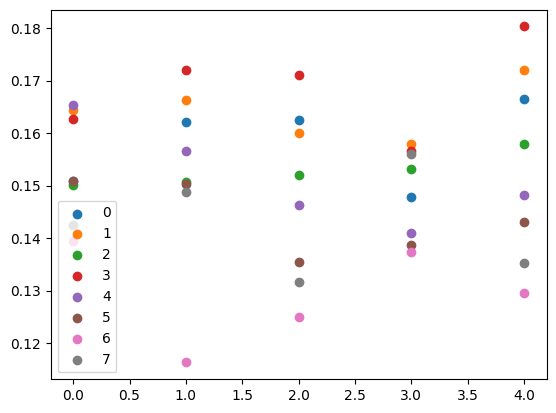

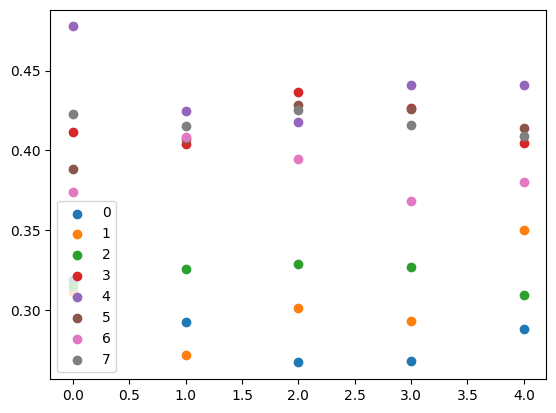

In [ ]:
split = np.arange(0,8)
trial = np.arange(0,5)

print(trial)
train_mse = {}
test_mse = {}

for i in range(len(split)):
    train_mse[split[i]] = []
    test_mse[split[i]] = []
    print(split[i])
    for k in range(n_trials):
        train_gt = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_Aiii_pt3/train_gt_split{split[i]}_{k}.npy")
        train_recon = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_Aiii_pt3/train_recon_split{split[i]}_{k}.npy")
        mse_train = np.linalg.norm(train_recon - train_gt) / np.linalg.norm(train_gt)
      
        test_gt = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_Aiii_pt3/test_gt_split{split[i]}_{k}.npy")
        test_recon = np.load(f"/home/amy/SHRED_neuro/worms/data_output/exp_Aiii_pt3/test_recon_split{split[i]}_{k}.npy")
        mse_test = np.linalg.norm(test_recon - test_gt) / np.linalg.norm(test_gt)
        
        train_mse[split[i]].append(mse_train)
        test_mse[split[i]].append(mse_test)

for z in range(len(split)):
    plt.scatter(np.arange(n_trials),train_mse[split[z]], label = f"{split[z]}")
plt.legend()
plt.show()


for z in range(len(split)):
    plt.scatter(np.arange(n_trials),test_mse[split[z]], label = f"{split[z]}")
plt.legend()

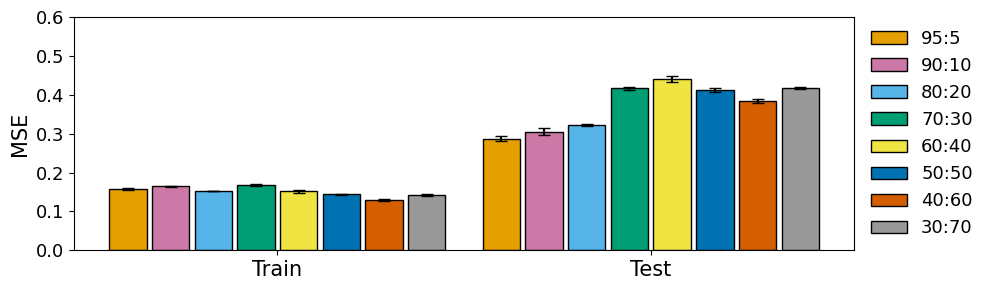

In [7]:
mean_one = [np.mean(train_mse[split[0]]), np.mean(test_mse[split[0]])]
mean_two = [np.mean(train_mse[split[1]]), np.mean(test_mse[split[1]])]
mean_three = [np.mean(train_mse[split[2]]), np.mean(test_mse[split[2]])]
mean_four = [np.mean(train_mse[split[3]]), np.mean(test_mse[split[3]])]
mean_five = [np.mean(train_mse[split[4]]), np.mean(test_mse[split[4]])]
mean_six = [np.mean(train_mse[split[5]]), np.mean(test_mse[split[5]])]
mean_seven = [np.mean(train_mse[split[6]]), np.mean(test_mse[split[6]])]
mean_eight = [np.mean(train_mse[split[7]]), np.mean(test_mse[split[7]])]


std_one = [np.std(train_mse[split[0]])/np.sqrt(8), np.std(test_mse[split[0]])/np.sqrt(8)]
std_two = [np.std(train_mse[split[1]])/np.sqrt(8), np.std(test_mse[split[1]])/np.sqrt(8)]
std_three = [np.std(train_mse[split[2]])/np.sqrt(8), np.std(test_mse[split[2]])/np.sqrt(8)]
std_four = [np.std(train_mse[split[3]])/np.sqrt(8), np.std(test_mse[split[3]])/np.sqrt(8)]
std_five = [np.std(train_mse[split[4]])/np.sqrt(8), np.std(test_mse[split[4]])/np.sqrt(8)]
std_six = [np.std(train_mse[split[5]])/np.sqrt(8), np.std(test_mse[split[5]])/np.sqrt(8)]
std_seven = [np.std(train_mse[split[6]])/np.sqrt(8), np.std(test_mse[split[6]])/np.sqrt(8)]
std_eight = [np.std(train_mse[split[7]])/np.sqrt(8), np.std(test_mse[split[7]])/np.sqrt(8)]


x = np.arange(len(mean_one))
labels = ['Train', 'Test']


train_test_split = ["95:5", "90:10", "80:20", "70:30", "60:40", "50:50", "40:60", "30:70"]

colors = [
    "#E69F00",  # orange
    "#CC79A7",  # reddish purple
    "#56B4E9",  # sky blue
    "#009E73",  # bluish green
    "#F0E442",  # yellow
    "#0072B2",  # blue
    "#D55E00",  # vermillion
    "#999999"   # gray
]

bar_width = 0.1
offsets = np.linspace(-bar_width*4, bar_width*4, 8)  

fig, ax = plt.subplots(figsize=(10, 3))

ax.bar(x + offsets[0], mean_one,   yerr=std_one,   capsize=4, width=bar_width, color=colors[0], edgecolor='black', label='Group 1')
ax.bar(x + offsets[1], mean_two,   yerr=std_two,   capsize=4, width=bar_width, color=colors[1], edgecolor='black', label='Group 2')
ax.bar(x + offsets[2], mean_three, yerr=std_three, capsize=4, width=bar_width, color=colors[2], edgecolor='black', label='Group 3')
ax.bar(x + offsets[3], mean_four,  yerr=std_four,  capsize=4, width=bar_width, color=colors[3], edgecolor='black', label='Group 4')
ax.bar(x + offsets[4], mean_five,  yerr=std_five,  capsize=4, width=bar_width, color=colors[4], edgecolor='black', label='Group 5')
ax.bar(x + offsets[5], mean_six,   yerr=std_six,   capsize=4, width=bar_width, color=colors[5], edgecolor='black', label='Group 6')
ax.bar(x + offsets[6], mean_seven, yerr=std_seven, capsize=4, width=bar_width, color=colors[6], edgecolor='black', label='Group 7')
ax.bar(x + offsets[7], mean_eight, yerr=std_eight, capsize=4, width=bar_width, color=colors[7], edgecolor='black', label='Group 8')


# Customize ticks and labels
ax.set_xticks(x)
ax.tick_params(axis='y', labelsize=13)
ax.set_ylim((0,0.6))
ax.set_xticklabels(labels, fontsize = 15)
ax.set_ylabel("MSE", fontsize = 15)
plt.legend(train_test_split,loc='center left', bbox_to_anchor=(1.0, 0.5), frameon=False, fontsize = 13)

plt.tight_layout()
plt.savefig("/home/amy/SHRED_neuro/worms/data_output/figs/mse_bar_split.png", transparent=True, dpi=500)

plt.show()